Plot the 3-worst WERs of the experiments of task weights and the experiments with learning rates. The y-axis is the 3-worst WER, and the x-axis is the ratio of the AC weight to the ASR weight for the first plot, and the ratio of the AC LR to the ASR LR for the second plot.

- The rest of the config is the same for both experiments. They are performed on B10.
- All task weight experiments are performed with the learning rate recommended by Nvidia to fine-tune the ASR model.
- All LR experiments are performed with AC weight = 0.1 (coupled).

In [1]:
import os
import json
import numpy as np
from omegaconf import OmegaConf
from matplotlib import pyplot as plt
import matplotlib

In [29]:
# increase the figure size and the font size
matplotlib.rcParams["figure.figsize"] = (6, 4)
matplotlib.rcParams.update({'font.size': 18})

In [3]:
# set the folder where the evaluation jobs are stored
eval_dir = "../../../logs/de/asr/evaluate"

# set the exp. types as keys and their experiments in the list
folders = {
    "w": [
        "version_32",
        "version_35",
        "version_40",
    ],
    "lr": [
        "version_26",
        "version_32",
        "version_41",
    ]
}

In [4]:
# convert the lists of experiments into dictionaries
for exp_type in folders:
    folders[exp_type] = {exp: dict() for exp in folders[exp_type]}

In [5]:
# find weights of weight experiments
for folder in folders["w"]:
    config = OmegaConf.load(os.path.join(eval_dir, folder, "hparams.yaml"))
    exp_folder = f'../{config.asr.ckpt.replace("/checkpoints/last.ckpt", "")}'
    exp_config = OmegaConf.load(os.path.join(exp_folder, "hparams.yaml"))
    if "weight" in exp_config.ensemble:  # weights are coupled
        folders["w"][folder] = {
            "ac": exp_config.ensemble.weight,
            "asr": 1 - exp_config.ensemble.weight,
        }
    else:  # weights are decoupled
        folders["w"][folder] = {
            "ac": exp_config.ensemble.ac_weight,
            "asr": exp_config.ensemble.asr_weight,
        }      
        

In [6]:
# find LRs of LR experiments
for folder in folders["lr"]:
    config = OmegaConf.load(os.path.join(eval_dir, folder, "hparams.yaml"))
    exp_folder = f'../{config.asr.ckpt.replace("/checkpoints/last.ckpt", "")}'
    exp_config = OmegaConf.load(os.path.join(exp_folder, "hparams.yaml"))
    folders["lr"][folder] = {"asr": exp_config.optim.lr}
    if "ac_args" in exp_config.optim:
        folders["lr"][folder]["ac"] = exp_config.optim.ac_args.lr
    else:
        folders["lr"][folder]["ac"] = folders["lr"][folder]["asr"]

In [7]:
# compute the avg. WER and the worst-3 WER for all experiments
seen_accents = ["de", "ch", "at"]
for exp_type in folders:
    for exp in folders[exp_type]:
        wers_dict = json.load(open(os.path.join(eval_dir, exp, "avg_wers.json")))
        wers_dict = {k.replace("test_", "").replace(".txt", ""): v for k, v in wers_dict.items()}
        wers = np.array([d["avg_wer"] for d in wers_dict.values()])
        folders[exp_type][exp]["avg. WER"] = np.mean(wers)*100
        folders[exp_type][exp]["worst-3 WER"] = np.mean(np.sort(wers, axis=0)[-3:])*100
        folders[exp_type][exp]["seen WER"] = np.mean([v["avg_wer"] for k, v in wers_dict.items() if k in seen_accents])*100
        folders[exp_type][exp]["unseen WER"] = np.mean([v["avg_wer"] for k, v in wers_dict.items() if k not in seen_accents])*100

# print one experiment to check the calculations are right
print(folders["w"]["version_32"])


{'ac': 0.1, 'asr': 0.9, 'avg. WER': 3.065591235887297, 'worst-3 WER': 4.958345943341769, 'seen WER': 2.3114270104977073, 'unseen WER': 3.348402820408394}


In [76]:
# plot the WER against the ratio, with a different x-axis per exp. type
def plot_wers(folders, wer_key):

    # compute the x and y arrays for each experiment type and sort them
    xs, ys = list(), list()
    for i, exp_type in enumerate(folders):
        x = np.array([exp["ac"] for exp in folders[exp_type].values()])
        y = np.array([exp[wer_key] for exp in folders[exp_type].values()])
        sort_idx = np.argsort(x)
        xs.append(x[sort_idx])
        ys.append(y[sort_idx])

    # plot the lines
    fig, ax = plt.subplots()
    line = ax.plot(xs[0], ys[0], label="Weights", color="blue")
    ax2 = ax.twiny()
    line2 = ax2.plot(xs[1], ys[1], label="LRs", color="red")
    lines = line + line2
    ax.legend(lines, [l.get_label() for l in lines], loc='upper left')

    # add axis labels
    ax.set_ylabel("WER (log.)")
    ax.set_xlabel("Classifier weight")
    ax2.set_xlabel("Classifier LR")

    # set the x-axis ticks to the values of the data and LRs in scientific notation
    ax.set_xticks(ticks=xs[0], labels=xs[0])
    ax2.set_xscale("log")
    ax2.set_xticks(ticks=xs[1], labels=[f"{x:.0e}".replace("-0", "-") for x in xs[1]])

    # set y-axis scale to log and ticks to actual values
    ax.set_yscale("log")
    ax.set_yticks(ticks=[2, 5, 10, 20, 50])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

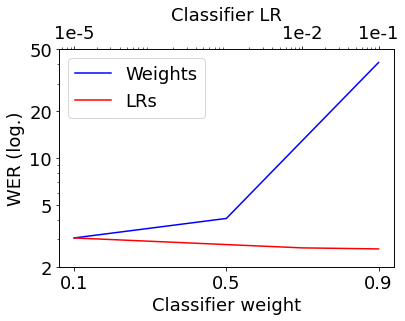

In [77]:
plot_wers(folders, "avg. WER")

These plots show that modifying the LRs is better than modifying the task weights. Now we want to show how modifying the LRs controls the influence of the AC, which is proven by a better 3-worst WER

([<matplotlib.axis.YTick at 0x7f90f031a280>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

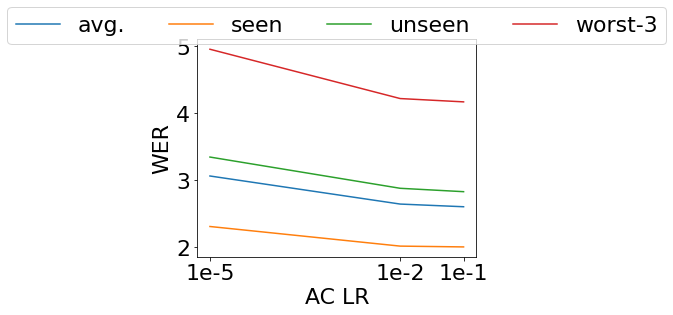

In [16]:
x = np.array([exp["ac"] for exp in folders["lr"].values()])
keys = ["avg. WER", "seen WER", "unseen WER", "worst-3 WER"]
sort_idx = np.argsort(x)
# plot the value of each key for each experiment in a different color
for key in keys:
    y = np.array([exp[key] for exp in folders["lr"].values()])
    plt.plot(x[sort_idx], y[sort_idx], label=key.replace(" WER", ""))

# plot the legend above the plot in one line
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
plt.xlabel("AC LR")
plt.ylabel("WER")
plt.xscale("log")
plt.xticks(ticks=x, labels=[f"{x:.0e}".replace("-0", "-") for x in x])
plt.yticks(ticks=[2,3,4,5])

Worst-3 accents decrease more than the rest: what is the improvement for each of these accent groups?

In [83]:
x = np.array([exp["ac"] for exp in folders["lr"].values()])
sort_idx = np.argsort(x)
for key in ["avg. WER", "seen WER", "unseen WER", "worst-3 WER"]:
    y = np.array([exp[key] for exp in folders["lr"].values()])[sort_idx]
    print(key, round(y[0] - y[1], 2), round(y[0] - y[2], 2))
    print("rel. improvement", round((y[0] - y[1])/y[0], 2), round((y[0] - y[2])/y[0], 2))


avg. WER 0.42 0.46
rel. improvement 0.14 0.15
seen WER 0.29 0.3
rel. improvement 0.13 0.13
unseen WER 0.47 0.52
rel. improvement 0.14 0.15
worst-3 WER 0.74 0.79
rel. improvement 0.15 0.16


In [12]:
x = np.array([exp["ac"] for exp in folders["lr"].values()])
sort_idx = np.argsort(x)
for key in ["avg. WER", "seen WER", "unseen WER", "worst-3 WER"]:
    y = np.array([exp[key] for exp in folders["lr"].values()])[sort_idx]
    print(key, y)

avg. WER [3.06559124 2.64639351 2.60636305]
seen WER [2.31142701 2.01842582 2.00647416]
unseen WER [3.34840282 2.88188139 2.83132138]
worst-3 WER [4.95834594 4.22200772 4.17249755]
